# The Discrete Fourier Transform

*This Jupyter notebook is part of a [collection of notebooks](../index.ipynb) in the bachelors module Signals and Systems, Comunications Engineering, Universität Rostock. Please direct questions and suggestions to [Sascha.Spors@uni-rostock.de](mailto:Sascha.Spors@uni-rostock.de).*

## Fast Fourier Transform

The discrete Fourier transformation (DFT) can be implemented computationally very efficiently by the [fast Fourier transform (FFT)](https://en.wikipedia.org/wiki/Fast_Fourier_transform). Various algorithms have been developed for the FFT resulting in various levels of computational efficiency for a wide range of DFT lengths. The concept of the so called [radix-2 Cooley–Tukey algorithm](https://en.wikipedia.org/wiki/Cooley%E2%80%93Tukey_FFT_algorithm) is introduced in the following.

### Radix-2 Decimation-in-Time Algorithm

Let's first consider the straightforward implementation of the DFT $X[\mu] = \text{DFT}_N \{ x[k] \}$ by its definition

\begin{equation}
X[\mu] = \sum_{k=0}^{N-1} x[k] \, w_N^{\mu k}
\end{equation}

where $w_N = e^{-j \frac{2 \pi}{N}}$. Evaluation of the definition for $\mu = 0,1,\dots,N-1$ requires $N^2$ complex multiplications and $N \cdot (N-1)$ complex additions. The numerical complexity of the DFT scales consequently [on the order of](https://en.wikipedia.org/wiki/Big_O_notation) $\mathcal{O} (N^2)$.

The basic idea of the radix-2 decimation-in-time (DIT) algorithm is to decompose the computation of the DFT into two summations: one over the even indexes $k$ of the signal $x[k]$ and one over the odd indexes. Splitting the definition of the DFT for an even lengths $N$ and rearranging terms yields

\begin{align}
X[\mu] &= \sum_{\kappa = 0}^{\frac{N}{2} - 1} x[2 \kappa] \, w_N^{\mu 2 \kappa} + 
\sum_{\kappa = 0}^{\frac{N}{2} - 1} x[2 \kappa + 1] \, w_N^{\mu (2 \kappa + 1)} \\
&= \sum_{\kappa = 0}^{\frac{N}{2} - 1} x[2 \kappa] \, w_{\frac{N}{2}}^{\mu \kappa} +
w_N^{\mu} \sum_{\kappa = 0}^{\frac{N}{2} - 1} \, x[2 \kappa + 1] w_{\frac{N}{2}}^{\mu \kappa} \\
&= X_1[\mu] + w_N^{\mu} \cdot X_2[\mu]
\end{align}

It follows from the last equality that the DFT can be decomposed into two DFTs $X_1[\mu]$ and $X_2[\mu]$ of length $\frac{N}{2}$ operating on the even and odd indexes of the signal $x[k]$. The decomposed DFT requires $2 \cdot (\frac{N}{2})^2 + N$ complex multiplications and $2 \cdot \frac{N}{2} \cdot (\frac{N}{2} -1) + N$ complex additions. For a length $N = 2^w$ with $w \in \mathbb{N}$ which is a power of two this principle can be applied recursively till a DFT of length $2$ is reached. This comprises then the radix-2 DIT algorithm. It requires $\frac{N}{2} \log_2 N$ complex multiplications and $N \log_2 N$ complex additions. The numerical complexity of the FFT algorithm scales consequently on the order of $\mathcal{O} (N \log_2 N)$. The notation DIT is due to the fact that the decomposition is performed with respect to the (time-domain) signal $x[k]$ and not its spectrum $X[\mu]$.

The derivation of the FFT following above principles for the case $N=8$ is illustrated using signal flow diagrams. The first decomposition results in

![Signal flow graph of two level radix-2 DIT FFT of length $N=8$](radix2_DIT_FFT_1.png)

where $\underset{a}{\oplus}$ denotes the weigthed summation $g[k] + a \cdot h[k]$ of two signals whereby the weighted signal $h[k]$ is denoted by the arrow. The same decomposition is now applied to each of the DFTs of length $\frac{N}{2} = 4$ resulting in two DFTs of length $\frac{N}{4} = 2$

![Signal flow graph of two level radix-2 DIT FFT of length $N=4$](radix2_DIT_FFT_2.png)

where $w_\frac{N}{2}^0 = w_N^0$, $w_\frac{N}{2}^1 = w_N^2$, $w_\frac{N}{2}^2 = w_N^4$ und $w_\frac{N}{2}^3 = w_N^6$. The resulting DFTs of length $2$ can be realized by

![Signal flow graph of DFT of length $N=2$](radix2_DIT_FFT_3.png)

where $w_2^0 = 1$ und $w_2^1 = -1$. Combining the decompositions yields the overall flow diagram of the FFT for $N=8$

![Signal flow graph of radix-2 DIT FFT of length $N=8$](radix2_DIT_FFT_4.png)

Further optimizations can be applied by noting that various common terms exist and that a sign reversal requires to swap only one bit in common representations of floating point numbers.

### Benchmark

The radix-2 DIT algorithm presented above can only be applied to lengths $N = 2^w$ which are are power of two. Similar and other principles can be applied to derive efficient algorithms for various other cases. A wide variety of implemented FFTs is available for many hardware platforms. Their computational efficiency depends heavily on the particular algorithm and hardware used. In the following the performance of the [`numpy.fft`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fft.html#numpy.fft.fft) function is evaluated by comparing the execution times of a [DFT realized by matrix/vector multiplication](definition.ipynb#Matrix/Vector-Representation) with the FFT algorithm. Note that the execution of the following cell may some time.

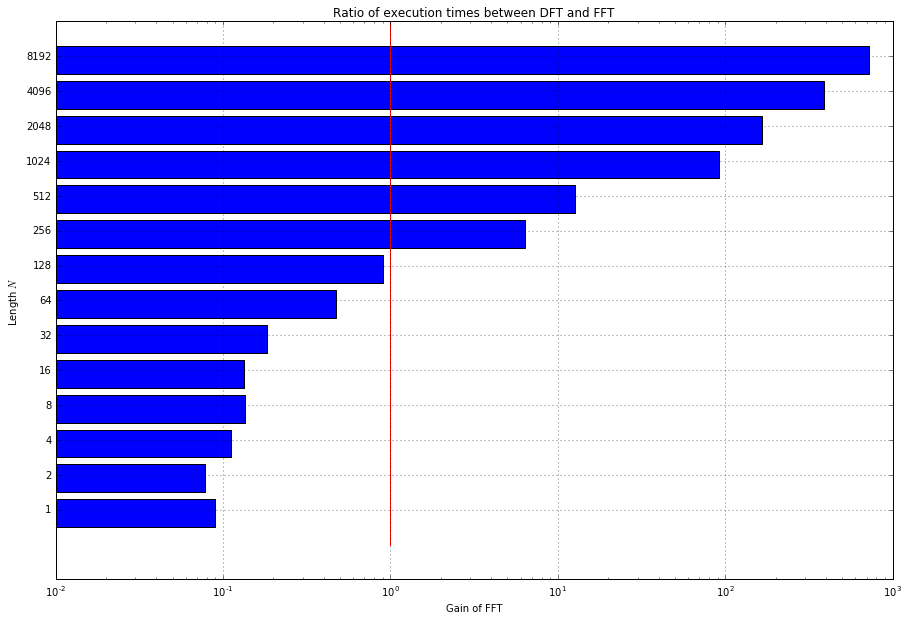

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import timeit

n = np.arange(14)  # lengths = 2**n to evaluate
reps = 100  # number of repetitions per measurement

# measure execution times
gain = np.zeros(len(n))
for N in n:
    length = 2**N
    # setup environment for timeit
    tsetup = 'import numpy as np; from scipy.linalg import dft;  \
            x=np.random.randn(%d)+1j*np.random.randn(%d); F = dft(%d)' % (length, length, length)
    # DFT
    tc = timeit.timeit('np.matmul(F, x)', setup=tsetup, number=reps)
    # FFT
    tf = timeit.timeit('np.fft.fft(x)', setup=tsetup, number=reps)
    # gain by using the FFT
    gain[N] = tc/tf

# show the results
plt.figure(figsize = (15, 10))
plt.barh(n-.5, gain, log=True)
plt.plot([1, 1], [-1, n[-1]+1], 'r-')
plt.yticks(n, 2**n)
plt.xlabel('Gain of FFT')
plt.ylabel('Length $N$')
plt.title('Ratio of execution times between DFT and FFT')
plt.grid()

**Exercise**

* For which lengths $N$ is the FFT algorithm faster than the direct computation of the DFT? 
* Why is it slower below a given length $N$?
* Does the trend of the gain follow the expected numerical complexity of the radix-2 FFT algorithm?

**Copyright**

The notebooks are provided as [Open Educational Resource](https://de.wikipedia.org/wiki/Open_Educational_Resources). Feel free to use the notebooks for your own educational purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: *Lecture Notes on Signals and Systems* by Sascha Spors.